In [56]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from xgboost import XGBRegressor

import matplotlib.pyplot as plt



df =  pd.read_csv("../bdd/processed/madrid_nettoye.csv")

df.columns
df.describe()

,id,sq_mt_built,n_rooms,n_bathrooms,rent_price,buy_price,buy_price_by_area
count,21742.000000,21616.000000,21742.000000,21726.000000,2.174200e+04,2.174200e+04,21742.000000
mean,10870.500000,146.920892,3.005749,2.091687,-5.917031e+04,6.537356e+05,4020.523871
std,6276.519112,134.181865,1.510497,1.406992,9.171162e+05,7.820821e+05,1908.418774
min,0.000000,13.000000,0.000000,1.000000,-3.459028e+07,3.600000e+04,447.000000
25%,5435.250000,70.000000,2.000000,1.000000,7.250000e+02,1.980000e+05,2551.000000
50%,10870.500000,100.000000,3.000000,2.000000,1.116000e+03,3.750000e+05,3720.000000
75%,16305.750000,162.000000,4.000000,2.000000,1.687000e+03,7.636000e+05,5000.000000
max,21741.000000,999.000000,24.000000,16.000000,2.517000e+03,8.800000e+06,18889.000000


In [57]:
#création d'une colonne pour le prix au m²

df["price_m2"] = (
    df['neighborhood_id']
    .str.extract(r"\(([\d\.]+)\s*€/m2\)")
    .astype(float)
)

#suppréssion des outliers
q1 = df["buy_price"].quantile(0.02)
q99 = df["buy_price"].quantile(0.98)
df = df[(df["buy_price"] >= q1) & (df["buy_price"] <= q99)]

#Regroupement des maisons et des duplex dans la meme catégorie car il n'y a pas assez de maison poue l'entrainement 
df["house_type_id"] = df["house_type_id"].replace({
    "HouseType 4: Dúplex": "HouseType 2/4: Casa/Duplex",
    "HouseType 2: Casa o chalet": "HouseType 2/4: Casa/Duplex"
})


In [72]:
X = df.drop(columns=["id","title","operation","subtitle",'neighborhood_id',"buy_price","buy_price_by_area","is_buy_price_known","rent_price","is_rent_price_known",'is_exact_address_hidden'])
X = X.dropna()
y = df["buy_price"]
y = y[X.index]  # garder les mêmes indices


numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()

# Y.head()
X.info()
# X["floor"].unique()

<class 'pandas.core.frame.DataFrame'>
Index: 18510 entries, 1 to 21739
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sq_mt_built         18510 non-null  float64
 1   n_rooms             18510 non-null  int64  
 2   n_bathrooms         18510 non-null  float64
 3   floor               18510 non-null  object 
 4   is_floor_under      18510 non-null  bool   
 5   house_type_id       18510 non-null  object 
 6   is_renewal_needed   18510 non-null  bool   
 7   is_new_development  18510 non-null  bool   
 8   has_lift            18510 non-null  bool   
 9   is_exterior         18510 non-null  bool   
 10  energy_certificate  18510 non-null  object 
 11  has_parking         18510 non-null  bool   
 12  price_m2            18510 non-null  float64
dtypes: bool(6), float64(3), int64(1), object(3)
memory usage: 1.2+ MB


In [36]:
X.head()

# df["subtitle"].nunique()
df["price_m2"].head()


1    1796.68
2    1617.18
3    1617.18
4    1827.79
5    1617.18
Name: price_m2, dtype: float64

Regression lineaire


In [37]:
RL_X = X.copy()
RL_y = y.copy()
RL_numerical_features = numerical_features.copy()
RL_categorical_features = categorical_features.copy()

In [38]:


X_train, X_test, y_train, y_test = train_test_split(
    RL_X,
    y,
    test_size=0.2,
    random_state=42
)


In [39]:
# standardisation des données numerique
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# transformation des valeur catégorielles en valeur numerique
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])



In [40]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.3f}")


RMSE : 192087.24
MAE  : 119945.70
R²   : 0.857


Random Forest


In [41]:
RF_X = X.copy()
RF_y = y.copy()
# RF_y = np.log1p(df["buy_price"])

RF_numerical_features = numerical_features.copy()
RF_categorical_features = categorical_features.copy()

In [42]:
RF_X_train, RF_X_test, RF_y_train, RF_y_test = train_test_split(
    RF_X,
    RF_y,
    test_size=0.2,
    random_state=42
)


In [43]:

RF_numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

RF_categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

RF_preprocessor = ColumnTransformer(
    transformers=[
        ("num", RF_numeric_transformer, RF_numerical_features),
        ("cat", RF_categorical_transformer, RF_categorical_features)
    ]
)

In [44]:
RF_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=25,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

In [45]:
RF_pipeline = Pipeline(steps=[
    ("preprocessor", RF_preprocessor),
    ("regressor", RF_model)
])


In [46]:
RF_pipeline.fit(RF_X_train, RF_y_train)

RF_y_pred = RF_pipeline.predict(RF_X_test)

 
RF_mae = mean_absolute_error(RF_y_test, RF_y_pred)
RF_r2 = r2_score(RF_y_test, RF_y_pred)
RF_mape = mean_absolute_percentage_error(RF_y_test, RF_y_pred)

print(f"RF MAE  : {RF_mae:,.0f} €")
print(f"RF R²   : {RF_r2:.3f}")
print(f"RF MAPE : {RF_mape*100:.2f} %")



RF MAE  : 75,591 €
RF R²   : 0.917
RF MAPE : 14.46 %


RF MAE   97,078 € : Veut dire que le modele peux faire un ecart dans le prediction jusqu'a + ou -  97,078 €

RF R²    0.891 : Veux dire que le modèle arrive a trouver une tendance et peux expliquer 89.1% de la variance du prix

RF MAPE  18.37 % : veux dire que le modele peux faire un ecart dans le prediction jusqu'a + ou -  18.37 %

XGboost

In [81]:
XGB_X = X.copy()
XGB_y = y.copy()  
XGB_numerical_features = numerical_features.copy()
XGB_categorical_features = categorical_features.copy()

In [1]:
XGB_X_train, XGB_X_test, XGB_y_train, XGB_y_test = train_test_split(
    XGB_X, XGB_y, test_size=0.2, random_state=42
)
# XGB_X_test.head()
XGB_y_test.head()

NameError: name 'train_test_split' is not defined

In [90]:
XGB_y_test.head()

15147    625000
16863    150000
368      230000
19553    419000
5970     154000
Name: buy_price, dtype: int64

création de la pipeline ( série d'étape afin de préparer les données pour entrainer le model)

In [83]:
#pipeline pour les données numérique , simpleimputer va remplir les valeurs  manquante

XGB_numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

#pipeline pour les données catégorielles , simpleimputer va remplir les valeurs  manquante et OneHotEncoder va transformer les données catégorielles en chiffres (exemple : quartier d'hozier = 1 , quartier des docks = 2 ect..)

XGB_categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

# regroupement des deux pipeline en une
XGB_preprocessor = ColumnTransformer([
    ("num", XGB_numeric_transformer, XGB_numerical_features)
    ,
    ("cat", XGB_categorical_transformer, XGB_categorical_features)
])



amélioration avec gridsearchCV


In [62]:
# XGB_pipeline = Pipeline([
#     ("preprocessor", XGB_preprocessor),
#     ("regressor", XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1))
# ])

# param_grid = {
#     "regressor__n_estimators": [500, 800, 1000],
#     "regressor__max_depth": [5, 6, 8],
#     "regressor__learning_rate": [0.03, 0.05, 0.1],
#     "regressor__subsample": [0.7, 0.8, 1.0],
#     "regressor__colsample_bytree": [0.7, 0.8, 1.0],
#     "regressor__reg_alpha": [0, 0.1, 0.5],
#     "regressor__reg_lambda": [1, 1.5, 2]
# }


# grid_search = GridSearchCV(
#     XGB_pipeline,
#     param_grid,
#     cv=3,                  
#     scoring="neg_mean_absolute_error", 
#     n_jobs=-1,
#     verbose=2
# )

# grid_search.fit(XGB_X_train, XGB_y_train)
# print("Best parameters:", grid_search.best_params_)
# print("Best MAE:", -grid_search.best_score_)


résultat du grid search cv :

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best parameters: {'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.03, 'regressor__max_depth': 8, 'regressor__n_estimators': 1000, 'regressor__reg_alpha': 0.1, 'regressor__reg_lambda': 1, 'regressor__subsample': 0.8}

Best MAE: 69329.40364583333

conclusion : nous n'avons rien gagné de significatif grace au grid search cv



In [84]:
XGB_model = XGBRegressor(
    colsample_bytree = 1.0, 
    learning_rate = 0.03, 
    max_depth = 8, 
    n_estimators = 1000, 
    reg_alpha = 0.1, 
    reg_lambda = 1,
    subsample= 0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1)


In [85]:
# application de la pipeline au modele

XGB_pipeline = Pipeline([
    ("preprocessor", XGB_preprocessor),
    ("regressor", XGB_model)
])


XGB_pipeline.fit(XGB_X_train, XGB_y_train)

# with open('../src/XGBoost.pkl' , 'wb') as file :
#     pickle.dump(XGB_pipeline,file)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [86]:
# XGB_y_pred = XGB_pipeline.predict(XGB_X_test)
# XGB_y_test_real = XGB_y_test  
test_villa = XGB_pipeline.predict(test)
print(test_villa)
 

# XGB_mae = mean_absolute_error(XGB_y_test_real, XGB_y_pred)
# XGB_r2 = r2_score(XGB_y_test_real, XGB_y_pred)
# XGB_mape = mean_absolute_percentage_error(XGB_y_test_real, XGB_y_pred)

# print(f"XGB MAE  : {XGB_mae:,.0f} €")
# print(f"XGB R²   : {XGB_r2:.3f}")
# print(f"XGB MAPE : {XGB_mape*100:.2f} %")


[1328868.4]


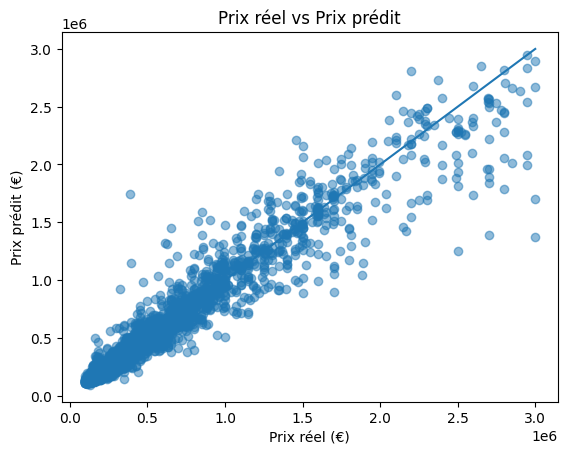

In [66]:

plt.figure()
plt.scatter(XGB_y_test_real, XGB_y_pred, alpha=0.5)

# ligne parfaite y = x
min_price = min(XGB_y_test_real.min(), XGB_y_pred.min())
max_price = max(XGB_y_test_real.max(), XGB_y_pred.max())
plt.plot([min_price, max_price], [min_price, max_price])

plt.xlabel("Prix réel (€)")
plt.ylabel("Prix prédit (€)")
plt.title("Prix réel vs Prix prédit")

plt.show()

MAE   68,461  € : Veut dire que le modele peux faire un ecart dans le prediction 
jusqu'a + ou - 68,461  €

R²    0.930    : Veux dire que le modèle arrive a trouver une tendance et explique 93 % de la variance du prix 
  
MAPE  13,33 %  : veux dire que le modele peux faire un ecart dans le prediction 
jusqu'a + ou - 13,33 % 





# Conclusion

MAE   68,461  € : sachant que la moyenne du prix des logement est de 650 000 , c'est pas mal  , il trompe dans une fourchette de 10% a -10 % du prix exact 

R²    0.930    : Plus le nombre est proche de 1 , plus il capte la tendance don 0.93 c'est pas très bien 
  
MAPE  13,33 %  : 13% est un chiffre a améliorer peut etre avec du meilleur data engineering ou avec beaucoup plus de données 

On voit sur le graphique que le plupart des  4000 données de test suivent la tendance tandis que quelques valeurs sortent de la droite . 

Il faudrait améliorer un peu plus le modele pour qu'il soit fiable est prédire exactement les prix de maison/appartements ou meme determiner un prix de logement, néanmoins il peut etre utiliser pour , par exemple vérifier si un prix est dans la fourchette attendue , voir si des logements sont sur ou sous estimé 